This is FEM coding for Classical Electrodynamic courses

2D situation.

Written by Zhibo Yu, 10.30.2020

'''This is a README line. I will write in Chinese for now.
有限元将每个研究的空间划分网格，形成元素(elements)，一般为三角形。
三角形的每个顶点为节点(nodes)

各个节点处的电势是需要直接求解的对象。每个元素内部可以根据节点的电势值设定插值函数，
这些插值函数在节点内部满足弱形式(weak fomulation)下的拉普拉斯方程。
若共有n个节点，定义待求解矢量V=[V1,V2,V3...,Vn]^T，可列出关于V的矩阵方程 KV=b

每个元素的内部，每个节点有属于自己的一个形函数(shape function),
节点内三个形函数的线性叠加便可以近似描述节点内部的电势。目前形函数均为线性的。

形函数

'''

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.path as path
import matplotlib as mpl
from scipy.spatial import Delaunay
from scipy.sparse.linalg import cg

#from scipy.sparse import csc_matrix
#from scipy.sparse.linalg import spsolve
from time import time
import numba as nb

In [12]:
####################################
##change parameters here
##WARNING: for now, only long >= width is acceptable
long = 20
width = 10
V0 = 1
rin = 1
rout = width/2
hout = 0.5
hin = 0.3
d = 0.5 #outer region distance
epsilon = 8.85*10**(-12)
ep_r = -1
#####################################

#creating mesh

#set the mesh
#suppose there are N layers of "circle-to-square" shell
N_outlayers = int(np.ceil((rout-rin)/(hout/2*np.sqrt(3))))
dr = (rout-rin)/N_outlayers
totnumNodes = 0

xy = [[0],[0]]  
x_y = [[0],[0]]
trans_mat90 = np.matrix([[np.cos(np.pi/2), np.sin(np.pi/2)],
                      [-np.sin(np.pi/2), np.cos(np.pi/2)]])
trans_mat45 = np.matrix([[np.cos(np.pi/4), np.sin(np.pi/4)],
                      [-np.sin(np.pi/4), np.cos(np.pi/4)]])


#in each layer
for i in range(N_outlayers+1):
    r = rin + i*dr
    t = (r-rin)/(rout-rin)
    
    N_points = int(np.ceil(np.pi/2*r/hout))

    for n in range(4):

        x = []
        y = []
        
        for j in range(N_points):

            dphi = np.pi/(2*N_points)
            phi = j*dphi + np.pi/4
            totnumNodes += 1            
            x.append((1 - t) * r * np.cos(phi - np.pi/4) + t * r * np.cos(phi - np.pi/4)/ np.cos(phi - np.pi/4 - np.pi/4))
            y.append((1 - t) * r * np.sin(phi - np.pi/4) + t * r * np.sin(phi - np.pi/4)/ np.cos(phi - np.pi/4 - np.pi/4))
        xy  = trans_mat90*xy
        x_y = np.vstack((x,y))       
        xy = np.hstack((xy,x_y))

xy = np.array(trans_mat45*xy)

#suppose there are other layers of shells in the innerpart
N_inlayers = int(np.ceil(rin)/(hin/2*np.sqrt(9)) + 1)
dr = rin/N_inlayers

x = []
y = []

#in each layer
for i in range(1, N_inlayers):
    r = i*dr
    N_points = int(np.ceil(2*np.pi*r/hin))
    
    for j in range(N_points):
        dphi  = 2*np.pi/(N_points)
        phi = j*dphi
        totnumNodes += 1
        x.append(r*np.cos(phi))
        y.append(r*np.sin(phi))
    x_y = np.vstack((x,y))
    xy = np.hstack((xy,x_y))

    
x = []
y = []
x_y = []
# in the outer rectangular region

if long > width:
    N_out_side_x = int(np.ceil((long - width)/(2*d)))
    N_out_side_y = int(np.ceil(width/d))
    dx = (long - width)/(2*N_out_side_x)
    dy = width/N_out_side_y

    #right region
    for i in range(1, N_out_side_x + 1):
        for j in range(N_out_side_y + 1):
            x.append(width/2 + i*dx)
            y.append(-width/2 + j*dy)
    #left region
    for i in range(1, N_out_side_x+ 1):
        for j in range(N_out_side_y + 1):
            x.append(-width/2 - i*dx)
            y.append(-width/2 + j*dy)
    x_y = np.vstack((x,y))
    xy = np.hstack((xy,x_y))
    
xNode = xy[0]
yNode = xy[1]
totnumEle = len(triang.simplices)
totnumNodes = len(xNode)
#store the indices of triangles in counter-clockwise
eleNode = triang.simplices
#the number of elements is 2*totnumBricks, while the number of nodes is totnumNodes
#each brick is partitioned into 2 elements

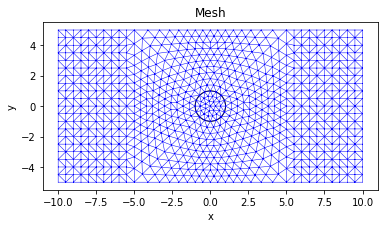

In [13]:
fig,ax = plt.subplots(1,1)
triang = Delaunay(np.transpose(xy))


circ=plt.Circle((0,0),radius=rin, color='black', fill=False,lw=1)
ax.add_patch(circ)
mesh = ax.triplot(xy[0],xy[1],triang.simplices,'b-',lw=0.5)
ax.set_aspect('equal')
ax.set_title(r'Mesh')
ax.set_xlabel('x')
ax.set_ylabel('y')
#ax.set_xlim(-2,2)
#ax.set_ylim(-2,2)


plt.show()


In [14]:
#fig.savefig("mesh.png",dpi=1000)

In [15]:
#######
#Define the intepolate function
#######
zi = int(200*long/5+1)
zj = int(200*width/5+1)

X = np.linspace(-long/2, long/2, zi)
Y = np.linspace(-width/2, width/2, zj)


@nb.njit
def interpolate(Zx):

    for i in range(len(X)):
        for j in range(len(Y)):
            for e in range(totnumEle):

                xlen10 = xNode[eleNode[e,1]]-xNode[eleNode[e,0]]
                xlen20 = xNode[eleNode[e,2]]-xNode[eleNode[e,0]]
                ylen10 = yNode[eleNode[e,1]]-yNode[eleNode[e,0]]
                ylen20 = yNode[eleNode[e,2]]-yNode[eleNode[e,0]]

                xlen0p = X[i]-xNode[eleNode[e,0]]
                ylen0p = Y[j]-yNode[eleNode[e,0]]

                xlen1p = X[i]-xNode[eleNode[e,1]]
                ylen1p = Y[j]-yNode[eleNode[e,1]]

                xlen2p = X[i]-xNode[eleNode[e,2]]
                ylen2p = Y[j]-yNode[eleNode[e,2]]

                A0 = 1/2*abs(xlen0p*ylen1p - xlen1p*ylen0p)
                A1 = 1/2*abs(xlen1p*ylen2p - xlen2p*ylen1p)
                A2 = 1/2*abs(xlen2p*ylen0p - xlen0p*ylen2p)
                Ae = 1/2*abs(xlen10*ylen20 - xlen20*ylen10)

                if abs(Ae - (A0+A1+A2)) <= 1e-5*Ae:
                    xi = (ylen20 * (X[i] - xNode[eleNode[e,0]]) - xlen20 * (Y[j] - yNode[eleNode[e,0]]))/(2*Ae)
                    eta = (-ylen10 * (X[i] - xNode[eleNode[e,0]]) +  xlen10 * (Y[j] - yNode[eleNode[e,0]]))/(2*Ae)
                    N1 = 1 - xi - eta
                    N2 = xi
                    N3 = eta
                    Zx[j, i] = V[eleNode[e, 0]]*N1 + V[eleNode[e, 1]]*N2 + V[eleNode[e, 2]]*N3
                    break




    return Zx


In [16]:
############################################################
### The fomula for second-order BVP:                      ##
### d/dx(a_x du/dx) + d/dx(a_y du/dy) + beta*u == g       ##
### for potential in vacuum, a_x = a_y = 1; beta = g = 0  ##
############################################################


a_x = np.ones(totnumEle)*epsilon
a_y = np.ones(totnumEle)*epsilon
beta = np.zeros(totnumEle)
g = np.zeros(totnumEle)

In [17]:

#Specify dielectric condition
for e in range(totnumEle):
    NodeInQ = []
    for i in range(3):
        if rin**2 - ((xNode[eleNode[e, i]])**2 + (yNode[eleNode[e, i]])**2) > -1e-6:
            NodeInQ.append(True)
        else:
            NodeInQ.append(False)
    
    if NodeInQ == [True, True, True]:
        a_x[e] = ep_r*epsilon
        a_y[e] = ep_r*epsilon



In [18]:
K = np.zeros((totnumNodes,totnumNodes))
b = np.zeros(totnumNodes)

for e in range(totnumEle):
    
    #red_x stores x01,x02,x12
    xlen = np.zeros((3,3))
    ylen = np.zeros((3,3))

    for i in range(3):
        for j in range(3):    
            xlen[i,j] = xNode[eleNode[e,i]]-xNode[eleNode[e,j]]
            ylen[i,j] = yNode[eleNode[e,i]]-yNode[eleNode[e,j]]

    #Surface area of an element
    Ae = 1/2*(xlen[0][1]*ylen[0][2] - xlen[0][2]*ylen[0][1])

    #dN_dx and dN_dy in natural coordinates \psi and \eta
    dN_dx = np.zeros(3)
    dN_dy = np.zeros(3)

    for i in range(3):
        dN_dx[i] = ylen[(i+1)%3, (i+2)%3]/(2*Ae)
        dN_dy[i] = xlen[(i+1)%3, (i+2)%3]/(2*Ae)

    #Constructing Me matrix
    Me = np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            Me[i,j] = -(a_x[e]*dN_dx[i]*dN_dx[j] + a_y[e]*dN_dy[i]*dN_dy[j])*2*Ae*1/2

    #Constructing Te matrix
    Te = np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            if i == j:
                Te[i,j] = beta[e]*Ae/6
            else:
                Te[i,j] = beta[e]*Ae/12

    Ke = Me + Te


    #Constructing fe matrix
    fe = np.zeros(3)
    for i in range(3):
        fe[i] = g[e]*Ae/3

    #Constructing pe matrix
    pe = np.zeros(3)
    
    be = fe + pe


    ###########################
    ###Constructing K matrix###
    ###########################

    for i in range(3):
        for j in range(3):
            K[eleNode[e,i], eleNode[e,j]] =  K[eleNode[e,i], eleNode[e,j]] + Ke[i,j]
        b[eleNode[e,i]] = b[eleNode[e,i]] + be[i]

In [19]:
#Specify the BCs
numNodesOnBC = 0
NodesOnBC = []
ValuesOnBC = []
NodesOnISO = []
numNodesOnISO = 0
for i in range(totnumNodes):
    if abs(xNode[i] - (-long/2)) < 1e-6:
        numNodesOnBC += 1
        NodesOnBC.append(i)
        ValuesOnBC.append(-V0)
    elif abs(xNode[i] - long/2) < 1e-6:
        numNodesOnBC += 1
        NodesOnBC.append(i)
        ValuesOnBC.append(V0)

#isosuface BC
    elif abs((xNode[i])**2 + (yNode[i])**2 - rin**2) < 1e-6:
        numNodesOnISO += 1
        NodesOnISO.append(i)

        
#Impose the BCs
'''
for i in range(numNodesOnISO - 1):
    K[:, NodesOnISO[i+1]] += K[:, NodesOnISO[i]]
    K[NodesOnISO[i+1], :] += K[NodesOnISO[i], :]  
    b[NodesOnISO[i+1]] += b[NodesOnISO[i]]
    
    K[:, NodesOnISO[i]] = 0
    K[NodesOnISO[i], :] = 0
    K[NodesOnISO[i], NodesOnISO[i]] = 1
    b[NodesOnISO[i]] = 0
'''



for i in range(numNodesOnBC):
    for j in range(totnumNodes):
        if j != NodesOnBC[i]:
            b[j] = b[j] - K[j, NodesOnBC[i]] * ValuesOnBC[i]

    K[:, NodesOnBC[i]] = 0
    K[NodesOnBC[i], :] = 0
    K[NodesOnBC[i], NodesOnBC[i]] = 1
    b[NodesOnBC[i]] = ValuesOnBC[i]   
    
    
#######################################
#Solve for v

#V = np.linalg.solve(K, b)    #for small size of mesh

#Conjugate Gradient Method
t1 = time()
V, converg_info = cg(K, b, tol = 10**(-16), atol=10**(-16))     #for large size of mesh
##### Be careful, tol cannot set too small

t2 = time()
########################################



#restore V on isosurface
'''
for q in NodesOnISO:
    V[q] = V[NodesOnISO[-1]]
'''
#

print("The total number of elements is", totnumEle)
print("The total number of nodes is", totnumNodes)

#see documentation for scipy.sparse.linalg.cg
if converg_info == 0:
    print("CG exits with success")
elif converg_info >= 0:
    print("Convergence to tolerance not achieved, number of iterations is {}".format(converg_info))
else:
    print("Illegal input or breakdown")

print("The time for solving linear equations is {:.3f}s".format(t2-t1))


The total number of elements is 1642
The total number of nodes is 885
CG exits with success
The time for solving linear equations is 0.098s


In [20]:
Zt = np.zeros((int(200*width/5+1), int(200*long/5+1)))
t3 = time()
Z = interpolate(Zt)
t4 = time()
print("Time used for interpolation: {:.3f}s".format(t4-t3))
Xgrid, Ygrid = np.meshgrid(X, Y)

Time used for interpolation: 3.796s


In [21]:
Z1 = np.zeros((len(Z),len(Z[0])))
Z2 = np.zeros((len(Z),len(Z[0])))

Z1=Z
              
for i in range(len(Z2)):
    for j in range(len(Z2[0])):
        Z2[i, j] = Z[i, j] - (-1 + 2*j/(len(Z2[0])-1))


In [22]:
Ey, Ex = np.gradient(-Z1,Y, X)
Eyd, Exd = np.gradient(-Z2, Y, X)

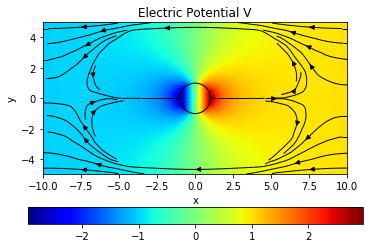

In [23]:
fig1, ax1 = plt.subplots(1,1, figsize=(6,4))

plt.jet()

levels = np.arange(-1,1,.1)
ims = ax1.imshow(Z1, extent=[-long/2, long/2, -width/2, width/2])
#con1 = ax1.contourf(Xgrid,Ygrid,Z, levels = np.arange(0,2.1,0.2))
#ax1.triplot(xy[0],xy[1],triang.simplices,color='black',lw=0.5)
circ=plt.Circle((0,0),radius=rin, color='black', fill=False,lw=1)
ax1.add_patch(circ)

arange_out = np.linspace(-width/2*(1-0.05), width/2*(1-0.05), 20)
arange_in = np.linspace(-rin*(1+0.5), rin*(1+0.5), 9)
stream_points = np.vstack((#np.array(list(zip(np.zeros(30),arange_in))),
                           np.array(list(zip(np.ones(30)*long/3,arange_out))),
                           np.array(list(zip(-np.ones(30)*long/3,arange_out)))))

ax1.streamplot(X, Y, Ex, Ey, color='black',
               density = 2,
               start_points=stream_points,
               linewidth=1, arrowstyle='-|>')

ax1.set_aspect('equal')
ax1.set_title(r'Electric Potential V')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
fig1.colorbar(ims, ax=ax1, orientation='horizontal')
plt.show()


In [24]:
#fig1.savefig("long_mesh_a_in=2.png", dpi = 1000)

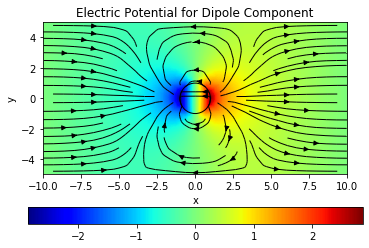

In [25]:
fig2, ax2 = plt.subplots(1,1,figsize=(6,4))

levels = np.arange(-1,1,.1)
ims2 = ax2.imshow(Z2, extent=[-long/2, long/2, -width/2, width/2])
#con2 = ax1.contourf(Xgrid,Ygrid,Z, levels = np.arange(0,2.1,0.2))
#ax2.triplot(xy[0],xy[1],triang.simplices,color='black',lw=0.5)
circ2=plt.Circle((0,0),radius=rin, color='black', fill=False,lw=1)
ax2.add_patch(circ2)

arange_out = np.linspace(-width/2*(1-0.05), width/2*(1-0.05), 20)
arange_in = np.linspace(-rin*(1+1), rin*(1+1), 29)
arange_in_cyl = np.linspace(-rin, rin, 10)

stream_points = np.vstack((np.array(list(zip(np.zeros(30),arange_in))),
                           np.array(list(zip(np.zeros(30),arange_in_cyl))),
                           np.array(list(zip(np.ones(30)*long/10,arange_out))),
                           np.array(list(zip(-np.ones(30)*long/10,arange_out))),
                           np.array(list(zip(np.ones(30)*long/3,arange_out))),
                           np.array(list(zip(-np.ones(30)*long/3,arange_out)))
                            ))

ax2.streamplot(X, Y, Exd, Eyd, color='black',
               density = 1,
               start_points=stream_points,
               linewidth=1, arrowstyle='-|>')
ax2.set_aspect('equal')
ax2.set_title(r'Electric Potential for Dipole Component')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
fig2.colorbar(ims2, ax=ax2, orientation = 'horizontal')
plt.show()


In [16]:
#fig2.savefig("long_mesh_dipole_component_a=2.png", dpi = 1000)